# Baseline Model

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (IndexLocator, FormatStrFormatter, AutoMinorLocator)
%matplotlib inline

conso = pd.read_csv('Ressources/Consommation des ménages trimestrielle.csv',sep=';')
conso = conso.set_index('Période').replace({',':'.'},regex=True).astype('float64')

var = []
for i in range(4,len(conso),1):
    var.append(float(conso['TOTAL '].iloc[i]/conso['TOTAL '].iloc[i-4] - 1))
yty_var = pd.DataFrame({'Variations de la consommation':var, 'Période':list(conso.index)[4:]})
yty_var = yty_var.set_index('Période')

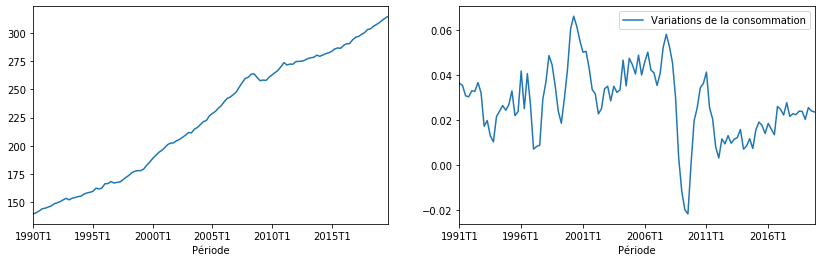

In [130]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4))
conso['TOTAL '].plot(ax=ax1,label='Dépenses de consommationd des ménages')
yty_var.plot(ax=ax2,label='Variations de la consommation')
plt.legend()
plt.show()

## Prédiction naïve (modèles AR)

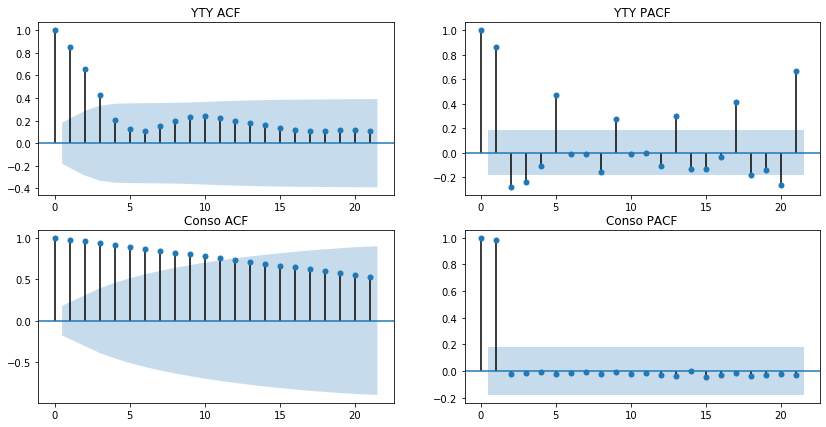

In [140]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig2, axes2 = plt.subplots(2,2, figsize=(14,7))
plot_acf(yty_var, ax=axes2[0][0], title="YTY ACF")
plot_pacf(yty_var, ax=axes2[0][1], title="YTY PACF")
plot_acf(conso['TOTAL '],ax=axes2[1][0], title="Conso ACF")
plot_pacf(conso['TOTAL '],ax=axes2[1][1], title="Conso PACF")
plt.show()

On peut ainsi envisager pour yty_var un ARMA(3,1).

In [141]:
from statsmodels.tsa.arima_model import ARMA

arma = ARMA()


In [113]:
pd.DataFrame(conso.iloc[:len(conso)-1,:]['TOTAL ']).merge(conso.iloc[:len(conso)-1-1,:]['TOTAL '],on='Période')

,TOTAL _x,TOTAL _y
Période,,
1990T1,139.6,139.6
1990T2,140.7,140.7
1990T3,142.3,142.3
1990T4,144.2,144.2
1991T1,144.7,144.7
...,...,...
2018T2,303.6,303.6
2018T3,305.9,305.9
2018T4,307.5,307.5


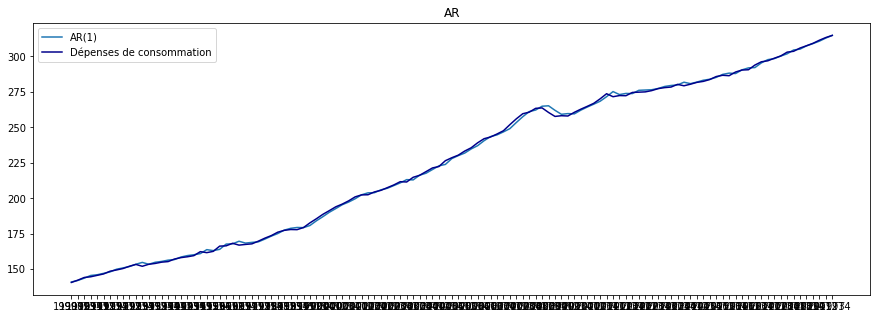

In [127]:
from sklearn.linear_model import LinearRegression
import numpy as np

figure, axes = plt.subplots(figsize=(15,5))


for i in range(1):
    reg = LinearRegression()
    Y = conso.iloc[1+i:,:]['TOTAL ']
    X = conso.iloc[:len(conso)-1-i,:]['TOTAL '][:,np.newaxis]
    reg.fit(X,Y)

    axes.plot(reg.predict(X),label='AR('+str(i+1)+')')
    axes.set_title('AR')

axes.plot(Y,color='darkblue',label='Dépenses de consommation')
plt.legend()
plt.show()

### En yty-var

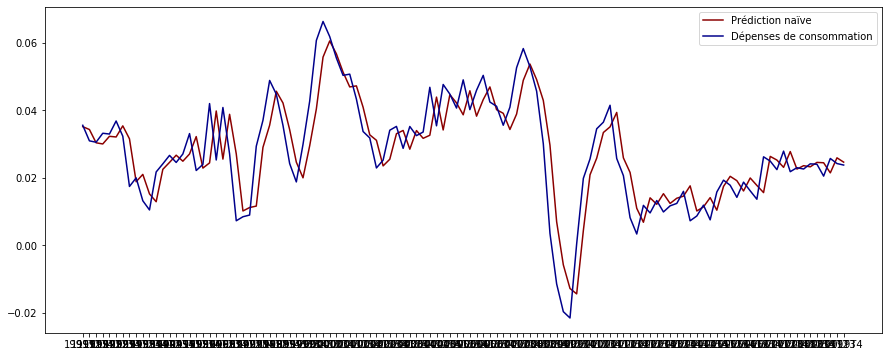

In [126]:
reg = LinearRegression()
Y = yty_var.iloc[1:,:]
X = yty_var.iloc[:len(yty_var)-1,:]['Variations de la consommation'][:,np.newaxis]

reg.fit(X,Y)

figure, axes = plt.subplots(figsize=(15,6))
axes.plot(reg.predict(X),color='darkred',label='Prédiction naïve')
axes.plot(Y,color='darkblue',label='Dépenses de consommation')

plt.legend()
plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller # Pour vérifier la trend-stationnarité de la série

In [27]:
result = adfuller(conso['TOTAL '],regression='ct')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.884954
p-value: 0.662429


Ce n'est absolument pas stationnaire.

In [23]:
result = adfuller(yty_var['Variations de la consommation'],regression='c')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.568250
p-value: 0.099738


La série dans son ensemble n'est pas vraiment trend-stationnaire...

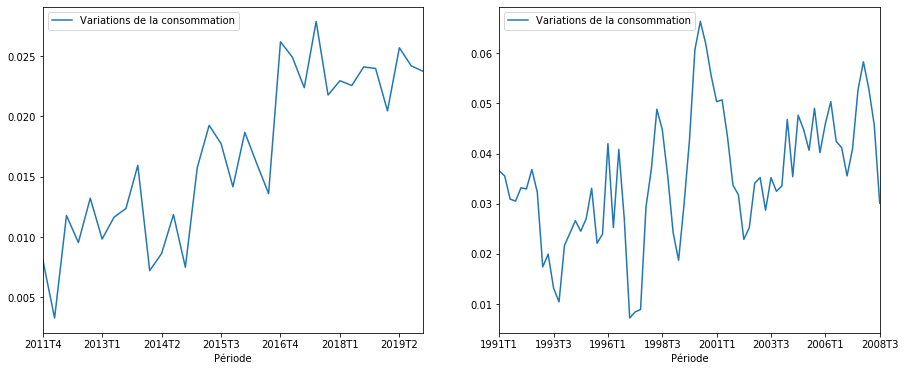

In [39]:
fig2, (ax3,ax4) = plt.subplots(1,2,figsize=(15,6))
yty_var.loc['2011T4':,:].plot(ax=ax3)
yty_var.loc[:'2008T3',:].plot(ax=ax4)
plt.show()

In [42]:
result = adfuller(yty_var.loc['2011T4':,:]['Variations de la consommation'],regression='ct')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.615165
p-value: 0.028588


A partir de du 3e trimestre de 2011, on retrouve une certaine trend-stationnarité.